In [1]:
import pandas as pd
import numpy as np
import os 
import scanpy as sc
import torch
import scvelo as scv

from pathlib import Path


In [2]:
notebook_dir = os.getcwd()
notebook_dir

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\notebooks\\velocity_notebooks'

In [3]:
Path(notebook_dir).parents[2]

WindowsPath('c:/Users/OmerCagatayTalikaci/Desktop/github')

In [4]:
os.chdir(Path(notebook_dir).parents[2])

In [5]:
import sys  
sys.path.insert(1,'c:/Users/OmerCagatayTalikaci/Desktop/github/')

In [1]:
import scvi

c:\Users\OmerCagatayTalikaci\anaconda3\envs\scvi-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from scvi.external import VELOVI , velovi

In [7]:
from pathlib import Path
from typing import Optional, Union
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import scvelo as scv
from anndata import AnnData
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(
    adata: AnnData,
    spliced_layer: Optional[str] = "Ms",
    unspliced_layer: Optional[str] = "Mu",
    min_max_scale: bool = True,
    filter_on_r2: bool = True,
) -> AnnData:
    """Preprocess data.

    This function removes poorly detected genes and minmax scales the data.

    Parameters
    ----------
    adata
        Annotated data matrix.
    spliced_layer
        Name of the spliced layer.
    unspliced_layer
        Name of the unspliced layer.
    min_max_scale
        Min-max scale spliced and unspliced
    filter_on_r2
        Filter out genes according to linear regression fit

    Returns
    -------
    Preprocessed adata.
    """
    if min_max_scale:
        scaler = MinMaxScaler()
        adata.layers[spliced_layer] = scaler.fit_transform(adata.layers[spliced_layer])

        scaler = MinMaxScaler()
        adata.layers[unspliced_layer] = scaler.fit_transform(
            adata.layers[unspliced_layer]
        )

    if filter_on_r2:
        scv.tl.velocity(adata, mode="deterministic")

        adata = adata[
            :, np.logical_and(adata.var.velocity_r2 > 0, adata.var.velocity_gamma > 0)
        ].copy()
        adata = adata[:, adata.var.velocity_genes].copy()

    return adata

In [8]:
from pipelines.simulate_3ode import *

In [9]:
mu = np.array([3, 1.8, 0.8, 0.5])

R = np.array([[.16, .128, .08, .032],
              [.128, .16 , .08, .032],
              [.08, .08, .16 , .08],
              [.032 ,.032 , .08 , .16]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

cov = C * R
#cov = R
cov=np.log(cov)
alpha, beta , nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size = 300).T)

In [10]:
def switch_times(t_max, n_vars):
    lower_bound = 0.05 * t_max
    upper_bound = 0.8 * t_max

    
    uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)

    return uniform_array

In [11]:
s = switch_times(20,300)

In [12]:
adata_s_u , adata_n_c = simulation_3ode(n_obs=800, t_max=20 ,alpha=alpha,nu=nu,gamma=gamma,beta=beta,switches=s/20,n_vars=300)

In [14]:
adata = adata_s_u.copy()

In [15]:
sc.pp.filter_cells(adata,min_counts = 20)
sc.pp.filter_genes(adata,min_cells = 4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors = 23  ,n_pcs=0)
sc.tl.umap(adata, min_dist=1)
sc.tl.leiden(adata)

In [17]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [21]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [22]:
adata

AnnData object with n_obs × n_vars = 800 × 220
    obs: 'true_t', 'n_counts', 'leiden'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [23]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [25]:
vae.to_device(device)

In [26]:
vae.train(max_epochs=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 8GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:37<00:00,  5.73it/s, v_num=1, train_loss_step=-465, train_loss_epoch=-464]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:37<00:00,  5.11it/s, v_num=1, train_loss_step=-465, train_loss_epoch=-464]


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

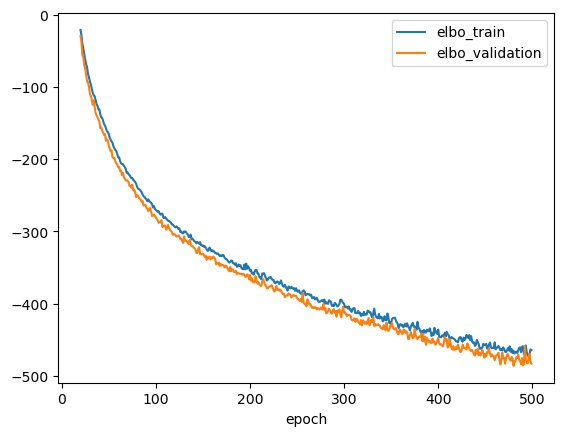

In [28]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [29]:
adata

AnnData object with n_obs × n_vars = 800 × 220
    obs: 'true_t', 'n_counts', 'leiden'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [30]:
latent_time = vae.get_latent_time(n_samples=25)

In [31]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    scaling = np.array(scaling)
    

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [32]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


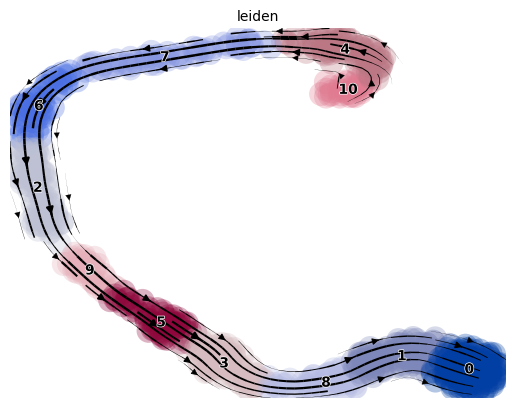

In [33]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='leiden')

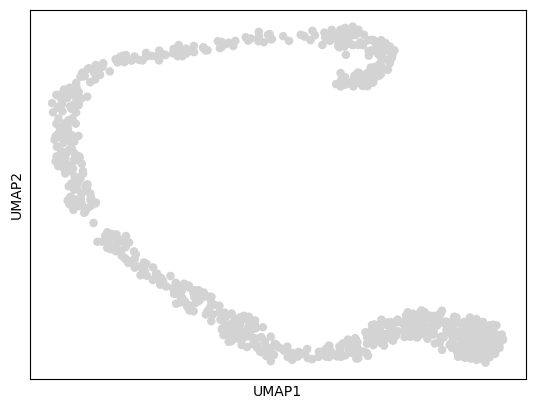

In [34]:
sc.pl.umap(adata)

In [55]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     Sampling from model...                                                                                    
INFO     Computing the uncertainties...                                                                            


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   39.6s finished


,directional_variance,directional_difference,directional_cosine_sim_variance,directional_cosine_sim_difference,directional_cosine_sim_mean
0,0.003179,0.180107,0.001001,0.101510,0.823804
1,0.006111,0.235551,0.002549,0.149973,0.769831
2,0.003406,0.180782,0.001109,0.103591,0.824334
3,0.003174,0.183662,0.001876,0.140295,0.645148
4,0.003851,0.176158,0.002403,0.138683,0.615697


In [56]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

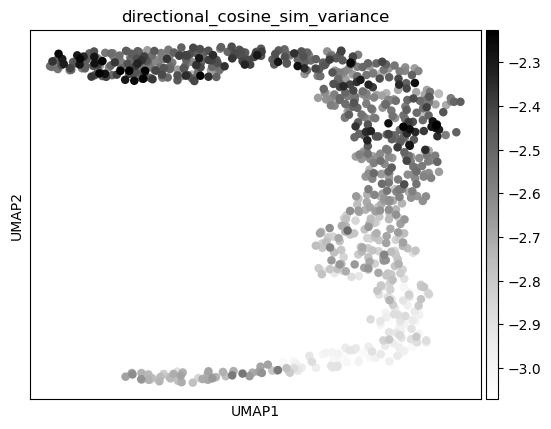

In [57]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
)

In [60]:
adata_velovi = adata.copy()

In [62]:
adata = adata_s_u.copy()

In [63]:
sc.pp.filter_cells(adata,min_counts = 20)
sc.pp.filter_genes(adata,min_cells = 4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [64]:
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors = 23  ,n_pcs=0)
sc.tl.umap(adata, min_dist=1)
sc.tl.leiden(adata)

In [66]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [67]:
scv.tl.recover_dynamics(adata,n_jobs=8)

recovering dynamics (using 8/24 cores)
    finished (0:00:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [68]:
scv.tl.velocity(adata, mode='dynamical')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [69]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/24 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


c:\Users\OmerCagatayTalikaci\anaconda3\envs\scvi-env\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\OmerCagatayTalikaci\anaconda3\envs\scvi-env\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


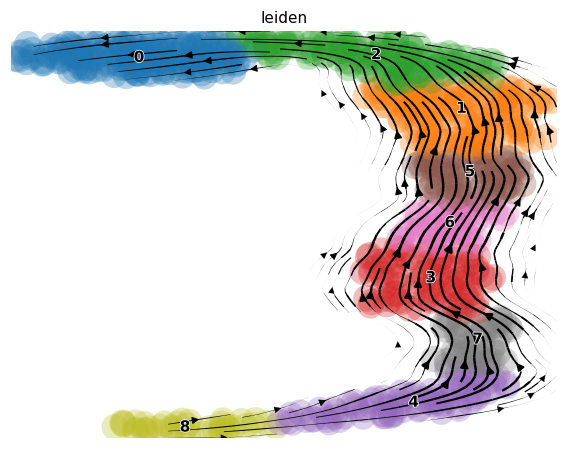

In [71]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color="leiden", dpi=110)

In [75]:
adata.var.columns

Index(['true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma',
       'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta',
       'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s',
       'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u',
       'fit_steady_s', 'fit_variance', 'fit_alignment_scaling',
       'velocity_genes'],
      dtype='object')